# 문제의 규정 및 본 파일의 구성
## 1) 문제의 규정
- 문제: 본문을 통해 프로젝트의 status를 추측하고 싶다.
- 가설: QA모델로 본문의 특징을 추출했을 때, 어떠한 status를 대표하는 vocabulary가 답변에 많이 나온다면 status를 추측할 수 있다.
- 하위 문제: 각 deal status별로 본문에서 가장 특징적인 vocabulary들을 어떻게 골라낼 것인가?
- 하위 문제 해결 후보 방법:  
1) word counting 후 중복 제거  
2) word appearance 확인 후 중복 제거  
3) 1을 기반으로 회귀분석 / vocab별 가중치에 따라 판단  
4) 1을 기반으로 의사결정나무 구성 / 변수의 중요도에 따라 판단

## 2) 본 파일의 구성
1. Preparations (Word Counting 수행, 라이브러리 등 불러오기)
2. Word Counting 파일 기본 속성 뜯어보기
3. Word Counting 후 중복 제거 (문제 해결 후보 1)
4. Word Appearance로 변환 후 중복 제거 (문제 해결 후보 2)
5. 회귀분석 (문제 해결 후보 3)
6. 의사결정나무 (문제 해결 후보 4)
7. 결론 및 개선점

# 1. Preparations
## 1) Count the vocabularies
### a. Tokenize the body texts and count each vocabs
#### (private repo) https://github.com/Sensodyne/sdp-vocab-selector.git
- Punctuations and stopwords were removed
- Normalized but not stemmed (소문자로 통일하였으나 단어를 기본형으로 바꾸지 않았음. 시제와 복수형태 등 살림)

## 2) Prepare the environment

In [1]:
# import packages and libraries
import pandas as pd
import numpy as np

# modules to draw charts
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

In [2]:
# environment settings for charts
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # 폰트는 맑은고딕
matplotlib.rcParams['axes.unicode_minus'] = False    # 마이너스 폰트 깨지는 것에 대해
plt.rcParams['figure.figsize'] = (17, 6)

In [3]:
# file path of the tsv file
file_path = 'word_counted.tsv'

In [4]:
# read the input
df = pd.read_csv(file_path, sep='\t')

In [5]:
# word_counted (DataFrame)
df

deal_status                                          body_text  \
0     operation  Saudi Arabia-headquartered utilities company A...   
1     operation  Saudi-based Acwa Power, a major developer of p...   
2     operation  Tata Power has an installed hydro power capaci...   
3     operation  The project will generate around 450 GWh of cl...   
4     operation  Adjaristsqali Georgia (AGL), a joint venture b...   
..          ...                                                ...   
872     Delayed  Hybrid solar-wind-battery complex in Australia...   
873     Delayed  Plans to build the $12 billion Inga 3 hydropow...   
874     Delayed  Global Coal Plant Tracker shows project pipeli...   
875     Delayed  Floating solar project schedule in Seychelles ...   
876     Delayed  The resource you are looking for might have be...   

                                             word_list  jb  nee  rank  \
0    ['east', 'nation', 'saudi', 'communities', 'ho...   0    0     0   
1    ['east', 'operating', 'also', 'saudi', 'commun...   0    0     0   
2    ['hpp', 'gases', 'tata', 'also', 'georgia', 'e...   0    0     0   
3    ['gases', 'hpp', 'exclusively', 'tata', 'georg...   0    0     0   
4    ['hpp', 'institutions', 'gases', 'generated', ...   0    0     0   
..                                                 ...  ..  ...   ...   
872  ['update', 'become', 'wind', 'ongoing', 'facin...   0    0     0   
873  ['image', 'de', 'operating', 'become', 'presid...   0    0     0   
874  ['highlighted', 'bengal', 'slowed', 'defence',...   0    0     0   
875  ['mahe', 'lagoon', 'selected', 'delay', 'news'...   0    0     0   
876  ['looking', 'resource', 'unavailable', 'name',...   0    0     0   

     configuration  analysers  grants  competes  ...  funneled  lodged  \
0                0          0       0         0  ...         0       0   
1                0          0       0         0  ...         0       0   
2                0          0       0         0  ...         0       0   
3                0          0       0         0  ...         0       0   
4                0          0       0         0  ...         0       0   
..             ...        ...     ...       ...  ...       ...     ...   
872              0          0       0         0  ...         0       0   
873              0          0       0         0  ...         0       0   
874              0          0       0         0  ...         0       0   
875              0          0       0         0  ...         0       0   
876              0          0       0         0  ...         0       0   

     prides  lisa  wants  heal  maclennan  ozkan  modernization  grade  
0         0     0      0     0          0      0              0      0  
1         0     0      0     0          0      0              0      0  
2         0     0      0     0          0      0              0      0  
3         0     0      0     0          0      0              0      0  
4         0     0      0     0          0      0              0      0  
..      ...   ...    ...   ...        ...    ...            ...    ...  
872       0     0      0     0          0      0              0      0  
873       0     0      0     0          0      0              0      0  
874       0     0      0     0          0      0              0      0  
875       0     0      0     0          0      0              0      0  
876       0     0      0     0          0      0              0      0  

[877 rows x 18286 columns]

# 2. Word Counting 파일 기본 속성 뜯어보기
## deal_status 값 확인

In [6]:
# unique values of the column 'deal_status'
df['deal_status'].unique()

array(['operation', 'Active', 'Cancelled', 'Delayed'], dtype=object)

### a. 'deal_status' == 'operation'

In [7]:
df_operation = df[df['deal_status'] == 'operation']
df_operation

deal_status                                          body_text  \
0     operation  Saudi Arabia-headquartered utilities company A...   
1     operation  Saudi-based Acwa Power, a major developer of p...   
2     operation  Tata Power has an installed hydro power capaci...   
3     operation  The project will generate around 450 GWh of cl...   
4     operation  Adjaristsqali Georgia (AGL), a joint venture b...   
..          ...                                                ...   
378   operation  This content is for Premium Subscribers only. ...   
383   operation  Russia’s new Platov International Airport, whi...   
384   operation  Bohol-Panglao International Airport has starte...   
394   operation  The Diplomat. 25/03/2018\n\nThe new terminal b...   
407   operation  Russian Aviaton » Friday December 8, 2017 12:5...   

                                             word_list  jb  nee  rank  \
0    ['east', 'nation', 'saudi', 'communities', 'ho...   0    0     0   
1    ['east', 'operating', 'also', 'saudi', 'commun...   0    0     0   
2    ['hpp', 'gases', 'tata', 'also', 'georgia', 'e...   0    0     0   
3    ['gases', 'hpp', 'exclusively', 'tata', 'georg...   0    0     0   
4    ['hpp', 'institutions', 'gases', 'generated', ...   0    0     0   
..                                                 ...  ..  ...   ...   
378  ['view', 'subscribe', 'subscribers', 'premium'...   0    0     0   
383  ['old', 'airbus', 'places', 'international', '...   0    0     0   
384  ['image', 'valencia', 'de', 'yet', 'flights', ...   0    0     0   
394  ['capacity', 'authority', 'potentials', 'compa...   0    0     0   
407  ['thursday', 'old', 'capacity', 'march', 'rece...   0    0     0   

     configuration  analysers  grants  competes  ...  funneled  lodged  \
0                0          0       0         0  ...         0       0   
1                0          0       0         0  ...         0       0   
2                0          0       0         0  ...         0       0   
3                0          0       0         0  ...         0       0   
4                0          0       0         0  ...         0       0   
..             ...        ...     ...       ...  ...       ...     ...   
378              0          0       0         0  ...         0       0   
383              0          0       0         0  ...         0       0   
384              0          0       0         0  ...         0       0   
394              0          0       0         0  ...         0       0   
407              0          0       0         0  ...         0       0   

     prides  lisa  wants  heal  maclennan  ozkan  modernization  grade  
0         0     0      0     0          0      0              0      0  
1         0     0      0     0          0      0              0      0  
2         0     0      0     0          0      0              0      0  
3         0     0      0     0          0      0              0      0  
4         0     0      0     0          0      0              0      0  
..      ...   ...    ...   ...        ...    ...            ...    ...  
378       0     0      0     0          0      0              0      0  
383       0     0      0     0          0      0              0      0  
384       0     0      0     0          0      0              0      0  
394       0     0      0     0          0      0              0      0  
407       0     0      0     0          0      0              0      0  

[373 rows x 18286 columns]

In [8]:
# the total frequency of appearance (top 500)
operation_sum = df_operation.sum(axis = 0, numeric_only = True)
operation_sum.sort_values(ascending = False, inplace = True)
operation_most_frequent = operation_sum.nlargest(500)
operation_most_frequent_vocab = operation_most_frequent.index.tolist()
"""Uncomment below to check the top 500"""
operation_most_frequent_vocab

['power',
 'energy',
 'project',
 'plant',
 'solar',
 'wind',
 'million',
 'mw',
 'said',
 'company',
 'capacity',
 'airport',
 'new',
 'operation',
 'commercial',
 'construction',
 'first',
 'also',
 'year',
 'operations',
 'electricity',
 'development',
 'per',
 'total',
 'terminal',
 'lng',
 'gas',
 'renewable',
 'expressway',
 'international',
 'projects',
 'one',
 'two',
 'unit',
 'farm',
 'expected',
 'generation',
 'group',
 'years',
 'facility',
 'china',
 'country',
 'located',
 'three',
 'passengers',
 'national',
 'geothermal',
 'us',
 'electric',
 'turbines',
 'market',
 'supply',
 'net',
 'largest',
 'started',
 'system',
 'services',
 'city',
 'local',
 'operating',
 'renewables',
 'may',
 'business',
 'december',
 'investment',
 'around',
 'government',
 'ormat',
 'plants',
 'completed',
 'clean',
 'region',
 'provide',
 'phase',
 'province',
 'south',
 'part',
 'time',
 'service',
 'share',
 'including',
 'announced',
 'adjusted',
 'ge',
 'last',
 'agreement',
 'world',

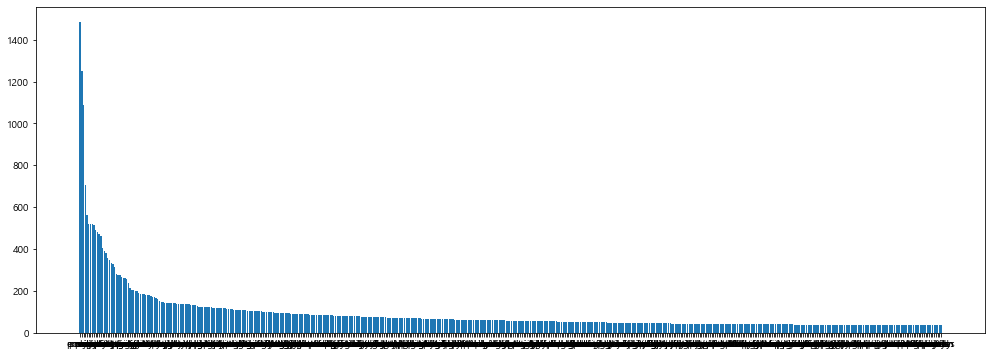

In [10]:
# top 500 graph
y = operation_most_frequent
x = y.index.tolist()

plt.bar(x, y)
plt.show()

In [9]:
operation_most_frequent.nlargest(300) # 50정도로 보겠음!

power        1484
energy       1250
project      1087
plant         708
solar         563
             ... 
leading        52
earnings       51
annual         51
financing      51
team           51
Length: 300, dtype: int64

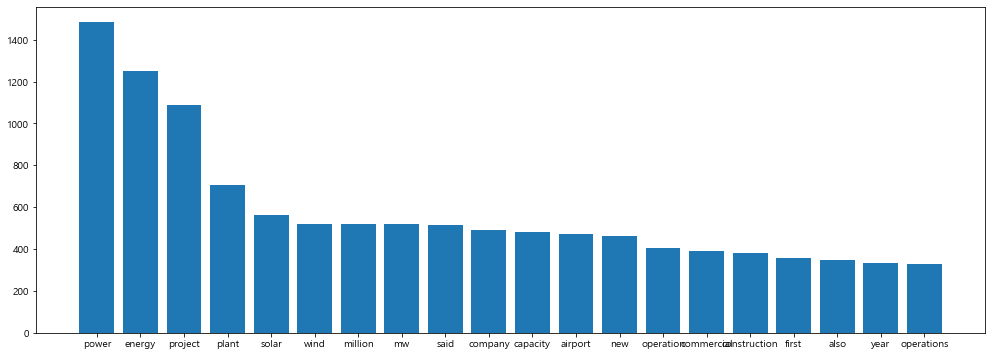

In [10]:
# top 20 graph
y = operation_most_frequent.nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

### b. 'deal_status' == 'Active'

In [9]:
df_active = df[df['deal_status'] == 'Active']
active_sum = df_active.sum(axis = 0, numeric_only = True)
active_sum.sort_values(ascending = False, inplace = True)
active_most_frequent = active_sum.nlargest(500)
active_most_frequent_vocab = active_most_frequent.index.tolist()
"""Uncomment below to check the top 100"""
# active_most_frequent_vocab

'Uncomment below to check the top 100'

In [10]:
active_most_frequent.nlargest(300) # 40정도로 보겠음!

project         1401
power           1222
construction     681
plant            629
dam              559
                ... 
help              42
like              42
existing          42
tunnels           42
chittagong        42
Length: 300, dtype: int64

### c. 'deal_status' == 'Cancelled'

In [11]:
df_cancelled = df[df['deal_status'] == 'Cancelled']
cancelled_sum = df_cancelled.sum(axis = 0, numeric_only = True)
cancelled_sum.sort_values(ascending = False, inplace = True)
cancelled_most_frequent = cancelled_sum.nlargest(500)
cancelled_most_frequent_vocab = cancelled_most_frequent.index.tolist()
"""Uncomment below to check the top 100"""
# cancelled_most_frequent_vocab

'Uncomment below to check the top 100'

In [12]:
cancelled_most_frequent.nlargest(300) # 20정도로 보겠음!

project     489
power       438
said        381
plant       305
projects    254
           ... 
although     19
meet         19
facility     19
works        19
link         19
Length: 300, dtype: int64

In [13]:
type(cancelled_most_frequent)

pandas.core.series.Series

### d. 'deal_status' == 'Delayed'

In [14]:
df_delayed = df[df['deal_status'] == 'Delayed']
delayed_sum = df_delayed.sum(axis = 0, numeric_only = True)
delayed_sum.sort_values(ascending = False, inplace = True)
delayed_most_frequent = delayed_sum.nlargest(500)
delayed_most_frequent_vocab = delayed_most_frequent.index.tolist()
"""Uncomment below to check the top 100"""
# delayed_most_frequent_vocab

'Uncomment below to check the top 100'

In [15]:
delayed_most_frequent.nlargest(300) # 20정도로 보겠음!

project         654
said            511
power           230
projects        215
construction    200
               ... 
cent             21
farm             21
estimated        21
result           21
needed           21
Length: 300, dtype: int64

In [16]:
overlapped_operation_active = (set(active_most_frequent_vocab) & set(operation_most_frequent_vocab))
overlapped_operation_cancelled = (set(operation_most_frequent_vocab) & set(cancelled_most_frequent_vocab))
overlapped_operation_delayed = (set(operation_most_frequent_vocab) & set(delayed_most_frequent_vocab))
overlapped_cancelled_delayed = (set(cancelled_most_frequent_vocab) & set(delayed_most_frequent_vocab))
overlapped_cancelled_active = (set(active_most_frequent_vocab) & set(cancelled_most_frequent_vocab))
overlapped_delayed_active = (set(active_most_frequent_vocab) & set(delayed_most_frequent_vocab))


# overlapped_whole = (set(active_most_frequent_vocab) & set(operation_most_frequent_vocab) &
#                   set(cancelled_most_frequent_vocab) & set(delayed_most_frequent_vocab))
overlapped_operation_active

{'able',
 'according',
 'activities',
 'added',
 'addition',
 'additional',
 'africa',
 'agreement',
 'air',
 'airport',
 'along',
 'already',
 'also',
 'announced',
 'annual',
 'another',
 'approximately',
 'april',
 'area',
 'around',
 'asia',
 'authority',
 'available',
 'bangladesh',
 'bank',
 'based',
 'become',
 'began',
 'billion',
 'bridge',
 'build',
 'building',
 'built',
 'business',
 'capacity',
 'capital',
 'cent',
 'central',
 'chief',
 'china',
 'chinese',
 'city',
 'coal',
 'combined',
 'commercial',
 'commission',
 'commissioned',
 'commissioning',
 'companies',
 'company',
 'complete',
 'completed',
 'completion',
 'constructed',
 'construction',
 'contract',
 'contractor',
 'corporation',
 'cost',
 'costs',
 'could',
 'country',
 'current',
 'currently',
 'day',
 'december',
 'demand',
 'design',
 'designed',
 'develop',
 'developed',
 'development',
 'director',
 'district',
 'domestic',
 'due',
 'east',
 'eastern',
 'economic',
 'economy',
 'electric',
 'electricit

# 3. Word Counting 후 중복 제거 (문제 해결 후보 1)

In [17]:
def exclude_overlapped_ones_simple(target_vocab:list, target:pd.core.series.Series, status1:set, status2:set, status3:set):
    excluded_indexer = list(set(target_vocab) - status1 - status2 - status3)
    excluded = target.loc[excluded_indexer]
    return excluded

In [18]:
operation_unique = exclude_overlapped_ones_simple(operation_most_frequent_vocab, operation_most_frequent, overlapped_operation_active, overlapped_operation_cancelled, overlapped_operation_delayed)
operation_unique_100 = operation_unique.nlargest(100)
operation_unique_100

net         143
ormat       132
adjusted    118
income      112
duke        109
           ... 
advanced     40
supreme      40
supplied     40
strong       40
formosa      40
Length: 100, dtype: int64

In [19]:
active_unique = exclude_overlapped_ones_simple(active_most_frequent_vocab, active_most_frequent, overlapped_operation_active, overlapped_cancelled_active, overlapped_delayed_active)
active_unique_100 = active_unique.nlargest(100)
active_unique_100

hydroelectric    105
tanzania          96
rampal            65
venezuela         64
lower             63
                ... 
cox               28
higher            28
biggest           28
engineer          28
flow              28
Length: 100, dtype: int64

In [20]:
delayed_unique = exclude_overlapped_ones_simple(delayed_most_frequent_vocab, delayed_most_frequent, overlapped_operation_delayed, overlapped_cancelled_delayed, overlapped_delayed_active)
delayed_unique_100 = delayed_unique.nlargest(100)
delayed_unique_100

coronavirus      65
delays           61
edf              59
outbreak         39
acquisition      33
                 ..
trade            15
ago              14
massachusetts    14
extension        14
spokesman        14
Length: 100, dtype: int64

In [21]:
cancelled_unique = exclude_overlapped_ones_simple(cancelled_most_frequent_vocab, cancelled_most_frequent, overlapped_operation_cancelled, overlapped_cancelled_delayed, overlapped_cancelled_active)
cancelled_unique_100 = cancelled_unique.nlargest(100)
cancelled_unique_100

cancelled       96
cancellation    55
kosovo          53
tender          48
mahathir        48
                ..
eia             15
letter          15
documents       15
court           14
malaysian       14
Length: 100, dtype: int64

In [14]:
# exclude overlapped ones (past attempt)
# operation_indexer = list(set(operation_most_frequent_vocab) - overlapped)
# active_indexer = list(set(active_most_frequent_vocab) - overlapped)
# cancelled_indexer = list(set(cancelled_most_frequent_vocab) - overlapped)
# delayed_indexer = list(set(delayed_most_frequent_vocab) - overlapped)

# operation_unique = operation_most_frequent.loc[operation_indexer]
# active_unique = active_most_frequent.loc[active_indexer]
# cancelled_unique = cancelled_most_frequent.loc[cancelled_indexer]
# delayed_unique = delayed_most_frequent.loc[delayed_indexer]

In [33]:
op = operation_unique.to_frame()
op.columns = ['frequency']
op

frequency
america            38
achieved           47
annually           65
balai              37
equity             48
...               ...
pacific            35
ceo               102
households         53
segment            38
best               38

[144 rows x 1 columns]

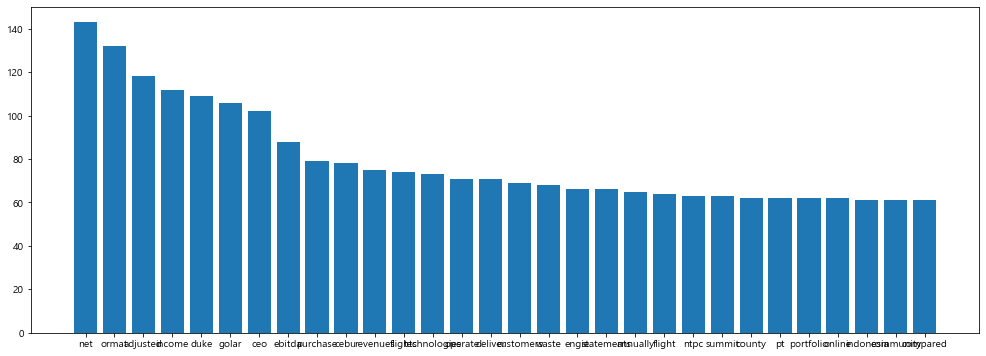

In [24]:
# The top 20s of the unique vocabs in the operation (commercial operation)
y = operation_unique.sort_values(ascending = False).nlargest(30)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

In [34]:
operation_unique.nlargest(30)

net             143
ormat           132
adjusted        118
income          112
duke            109
golar           106
ceo             102
ebitda           88
purchase         79
cebu             78
revenues         75
flights          74
technologies     73
deliver          71
operate          71
customers        69
waste            68
engie            66
statements       66
annually         65
flight           64
summit           63
ntpc             63
online           62
pt               62
portfolio        62
county           62
community        61
compared         61
indonesia        61
dtype: int64

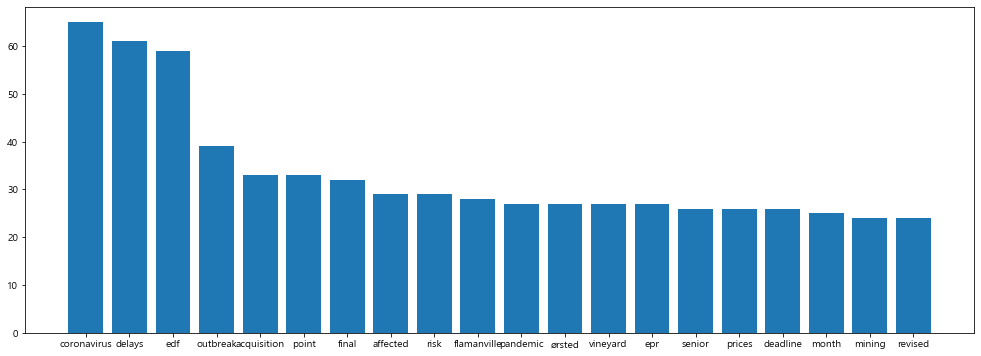

In [26]:
# The top 20s of the unique vocabs in the operation
y = delayed_unique.sort_values(ascending = False).nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

In [27]:
delayed_unique.nlargest(50)

coronavirus    65
delays         61
edf            59
outbreak       39
acquisition    33
point          33
final          32
affected       29
risk           29
flamanville    28
pandemic       27
ørsted         27
vineyard       27
epr            27
senior         26
deadline       26
prices         26
month          25
revised        24
mining         24
problem        23
informed       23
department     23
testing        22
home           22
latest         22
coming         22
give           22
gemini         22
price          22
french         21
mr             21
needed         21
possible       21
hinkley        21
budget         21
authorities    21
asn            21
bullet         20
permit         20
sindh          20
lao            20
know           19
get            19
virus          19
behind         19
nigeria        19
confirmed      19
situation      19
tk             19
dtype: int64

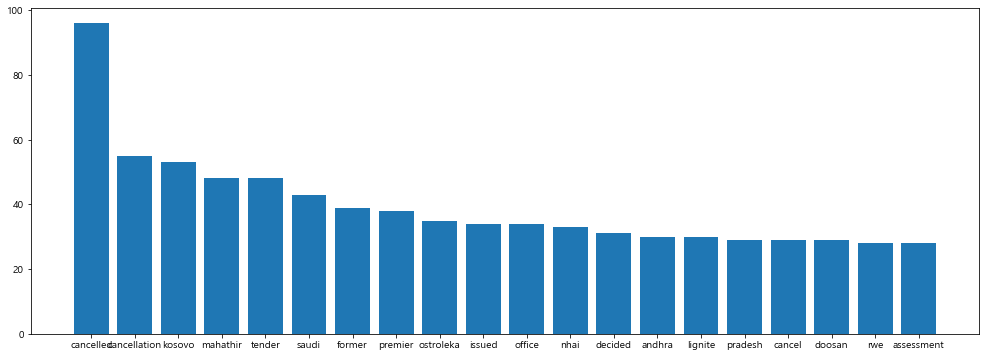

In [28]:
# The top 20s of the unique vocabs in the operation
y = cancelled_unique.sort_values(ascending = False).nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

In [29]:
cancelled_unique.nlargest(50)

cancelled       96
cancellation    55
kosovo          53
mahathir        48
tender          48
saudi           43
former          39
premier         38
ostroleka       35
issued          34
office          34
nhai            33
decided         31
lignite         30
andhra          30
pradesh         29
doosan          29
cancel          29
rwe             28
assessment      28
gmr             28
european        26
opposition      25
cabinet         25
oakville        25
softbank        25
tuesday         24
saying          24
strategic       23
pljevlja        23
ecrl            22
staff           22
party           22
citing          21
poland          21
terminated      21
suspended       21
euros           21
amaravati       21
energa          21
tolgoi          20
beijing         20
arabia          20
industries      20
tce             20
although        19
kuwait          18
proceed         18
enea            18
bpc             18
dtype: int64

- 데이터의 편향성이 매우 잘 나타나는 결과물
- 리서치팀 의견: 특정 회사의 언급 및 언론사가 강조하고자 하는 부문에 단어 집중
- 단어 사용 시 걸러내는 작업 필요함

# 4. Word Appearance로 변환 후 중복 제거 (문제 해결 후보 2)

In [30]:
df_app = df
for col in df.columns:
    if col == 'deal_status' or col == 'body_text' or col == 'word_list':
        continue
    else:
        df_app.loc[df_app[col] > 0, col] = 1
df_app

deal_status                                          body_text  \
0     operation  Saudi Arabia-headquartered utilities company A...   
1     operation  Saudi-based Acwa Power, a major developer of p...   
2     operation  Tata Power has an installed hydro power capaci...   
3     operation  The project will generate around 450 GWh of cl...   
4     operation  Adjaristsqali Georgia (AGL), a joint venture b...   
..          ...                                                ...   
872     Delayed  Hybrid solar-wind-battery complex in Australia...   
873     Delayed  Plans to build the $12 billion Inga 3 hydropow...   
874     Delayed  Global Coal Plant Tracker shows project pipeli...   
875     Delayed  Floating solar project schedule in Seychelles ...   
876     Delayed  The resource you are looking for might have be...   

                                             word_list  jb  nee  rank  \
0    ['east', 'nation', 'saudi', 'communities', 'ho...   0    0     0   
1    ['east', 'operating', 'also', 'saudi', 'commun...   0    0     0   
2    ['hpp', 'gases', 'tata', 'also', 'georgia', 'e...   0    0     0   
3    ['gases', 'hpp', 'exclusively', 'tata', 'georg...   0    0     0   
4    ['hpp', 'institutions', 'gases', 'generated', ...   0    0     0   
..                                                 ...  ..  ...   ...   
872  ['update', 'become', 'wind', 'ongoing', 'facin...   0    0     0   
873  ['image', 'de', 'operating', 'become', 'presid...   0    0     0   
874  ['highlighted', 'bengal', 'slowed', 'defence',...   0    0     0   
875  ['mahe', 'lagoon', 'selected', 'delay', 'news'...   0    0     0   
876  ['looking', 'resource', 'unavailable', 'name',...   0    0     0   

     configuration  analysers  grants  competes  ...  funneled  lodged  \
0                0          0       0         0  ...         0       0   
1                0          0       0         0  ...         0       0   
2                0          0       0         0  ...         0       0   
3                0          0       0         0  ...         0       0   
4                0          0       0         0  ...         0       0   
..             ...        ...     ...       ...  ...       ...     ...   
872              0          0       0         0  ...         0       0   
873              0          0       0         0  ...         0       0   
874              0          0       0         0  ...         0       0   
875              0          0       0         0  ...         0       0   
876              0          0       0         0  ...         0       0   

     prides  lisa  wants  heal  maclennan  ozkan  modernization  grade  
0         0     0      0     0          0      0              0      0  
1         0     0      0     0          0      0              0      0  
2         0     0      0     0          0      0              0      0  
3         0     0      0     0          0      0              0      0  
4         0     0      0     0          0      0              0      0  
..      ...   ...    ...   ...        ...    ...            ...    ...  
872       0     0      0     0          0      0              0      0  
873       0     0      0     0          0      0              0      0  
874       0     0      0     0          0      0              0      0  
875       0     0      0     0          0      0              0      0  
876       0     0      0     0          0      0              0      0  

[877 rows x 18286 columns]

In [31]:
# Check if the conversion worked well
df_app.max()

deal_status                                              operation
body_text        ‘Military tactics are like water, for water in...
word_list        ['ørsted', 'current', 'change', 'economically'...
jb                                                               1
nee                                                              1
                                       ...                        
heal                                                             1
maclennan                                                        1
ozkan                                                            1
modernization                                                    1
grade                                                            1
Length: 18286, dtype: object

In [32]:
# function to calculate the frequency
def return_frequency(input_df:pd.DataFrame, column:str, status:str, n:int):
    df_by_status = input_df[input_df[column] == status]
    app_sum = df_by_status.sum(axis = 0, numeric_only = True)
    most_frequent = app_sum.nlargest(n)
    most_frequent_vocab = most_frequent.index.tolist()
    return most_frequent, most_frequent_vocab

In [33]:
# calculate the frequency using the function and get the top 500
app_operation_frequency, app_operation_vocab = return_frequency(df_app, 'deal_status', 'operation', 500)
app_active_frequency, app_active_vocab = return_frequency(df_app, 'deal_status', 'Active', 500)
app_cancelled_frequency, app_cancelled_vocab = return_frequency(df_app, 'deal_status', 'Cancelled', 500)
app_delayed_frequency, app_delayed_vocab = return_frequency(df_app, 'deal_status', 'Delayed', 500)

In [34]:
# find the overlapped ones
app_overlapped_operation_cancelled = (set(app_operation_vocab) & set(app_cancelled_vocab))
app_overlapped_operation_delayed = (set(app_operation_vocab) & set(app_delayed_vocab))
app_overlapped_operation_active = (set(app_operation_vocab) & set(app_active_vocab))
app_overlapped_cancelled_delayed = (set(app_cancelled_vocab) & set(app_delayed_vocab))
app_overlapped_cancelled_active = (set(app_cancelled_vocab) & set(app_active_vocab))
app_overlapped_delayed_active = (set(app_delayed_vocab) & set(app_active_vocab))

In [35]:
# get rid of the overlapped vocabs
app_operation_unique = exclude_overlapped_ones_simple(app_operation_vocab, app_operation_frequency, app_overlapped_operation_cancelled, app_overlapped_operation_delayed, app_overlapped_operation_active)
app_operation_unique_100 = app_operation_unique.nlargest(100)
app_operation_unique_100

ceo           80
clean         76
online        49
growing       44
tonnes        43
              ..
contribute    23
dioxide       23
serving       23
aviation      23
de            23
Length: 100, dtype: int64

In [36]:
app_cancelled_unique = exclude_overlapped_ones_simple(app_cancelled_vocab, app_cancelled_frequency, app_overlapped_operation_cancelled, app_overlapped_cancelled_delayed, app_overlapped_cancelled_active)
app_cancelled_unique_100 = app_cancelled_unique.nlargest(100)
app_cancelled_unique_100

cancelled       62
cancellation    27
decided         26
former          21
cancel          21
                ..
show             8
overseas         8
relevant         8
quoted           8
legal            8
Length: 97, dtype: int64

In [37]:
app_delayed_unique = exclude_overlapped_ones_simple(app_delayed_vocab, app_delayed_frequency, app_overlapped_operation_delayed, app_overlapped_cancelled_delayed, app_overlapped_delayed_active)
app_delayed_unique_100 = app_delayed_unique.nlargest(100)
app_delayed_unique_100

delays         43
coronavirus    25
final          23
pandemic       19
give           19
               ..
steel          10
house          10
virus          10
impacted       10
till           10
Length: 80, dtype: int64

In [38]:
app_active_unique = exclude_overlapped_ones_simple(app_active_vocab, app_active_frequency, app_overlapped_operation_active, app_overlapped_cancelled_active, app_overlapped_delayed_active)
app_active_unique_100 = app_active_unique.nlargest(100)
app_active_unique_100

hydroelectric    39
hydro            36
tunnel           35
pakistan         34
length           33
                 ..
islamabad        18
kilometers       18
underground      18
division         18
communities      17
Length: 69, dtype: int64

In [20]:
# exclude overlapped ones (past attempt)
# app_overlapped = (set(app_operation_vocab) & set(app_active_vocab) &
#                   set(app_cancelled_vocab) & set(app_delayed_vocab))
# app_overlapped = (set(app_cancelled_vocab) & set(app_delayed_vocab) & set(app_operation_vocab))

# app_operation_indexer = list(set(app_operation_vocab) - app_overlapped)
# app_active_indexer = list(set(app_active_vocab) - app_overlapped)
# app_cancelled_indexer = list(set(app_cancelled_vocab) - app_overlapped)
# app_delayed_indexer = list(set(app_delayed_vocab) - app_overlapped)

# app_operation_unique = app_operation_frequency.loc[app_operation_indexer]
# app_active_unique = app_active_frequency.loc[app_active_indexer]
# app_cancelled_unique = app_cancelled_frequency.loc[app_cancelled_indexer]
# app_delayed_unique = app_delayed_frequency.loc[app_delayed_indexer]

In [21]:
# app_overlapped

{'according',
 'also',
 'capacity',
 'company',
 'completed',
 'construction',
 'cost',
 'country',
 'development',
 'electricity',
 'energy',
 'expected',
 'first',
 'government',
 'including',
 'infrastructure',
 'international',
 'last',
 'local',
 'may',
 'million',
 'national',
 'new',
 'one',
 'part',
 'per',
 'plant',
 'power',
 'project',
 'projects',
 'said',
 'state',
 'three',
 'time',
 'total',
 'two',
 'year',
 'years'}

#### 시도 1 (0829)
- operation & active 사이 overlapped 없음 / active와 cancelled, active와 delayed 사이 overlapped는 'report' only
- active만 혼자서 단어군이 매우 튀는 것을 확인할 수 있음
- 따라서, overlap되는 단어들은 active만 제외하고 나머지를 &연산을 함.

#### 시도 2 (0902)
- active의 단어군이 튀는 경우 해결 (단어군을 top 100에서 top 500으로 늘렸더니 겹치는 부분 다수 생김)
- overlap되는 단어들을 두 status간의 overlap만 성사되어도 제외하는 것으로 함

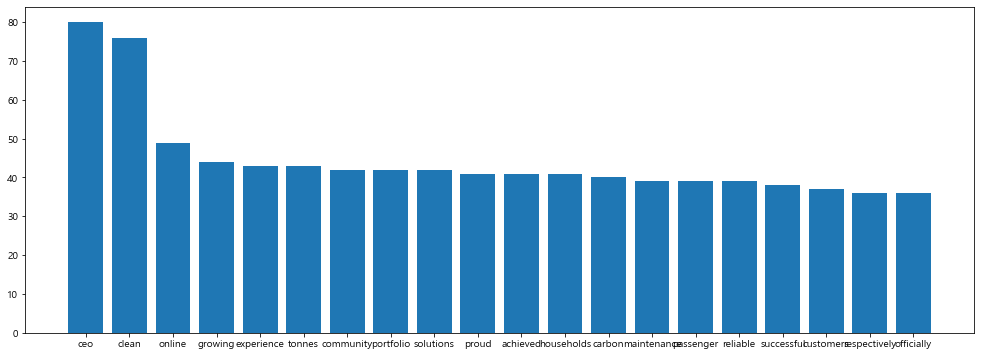

In [39]:
y = app_operation_unique.sort_values(ascending = False).nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

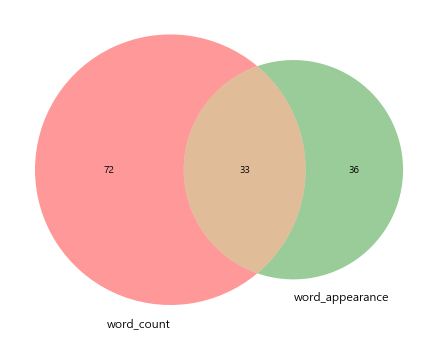

In [40]:
active = set(active_unique.index)
app_active = set(app_active_unique.index)
venn2([active, app_active], set_labels = ('word_count', 'word_appearance'))
plt.show()

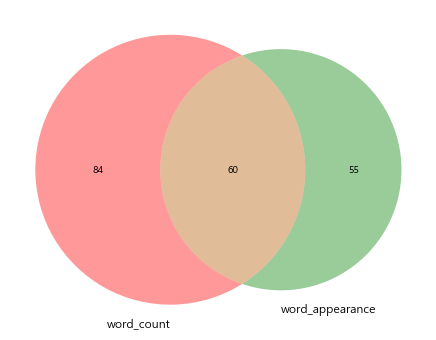

In [41]:
operation = set(operation_unique.index)
app_operation = set(app_operation_unique.index)
venn2([operation, app_operation], set_labels = ('word_count', 'word_appearance'))
plt.show()

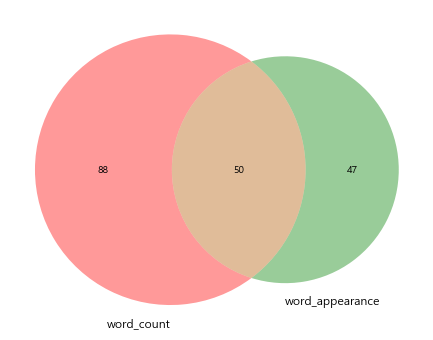

In [42]:
cancelled = set(cancelled_unique.index)
app_cancelled = set(app_cancelled_unique.index)
venn2([cancelled, app_cancelled], set_labels = ('word_count', 'word_appearance'))
plt.show()

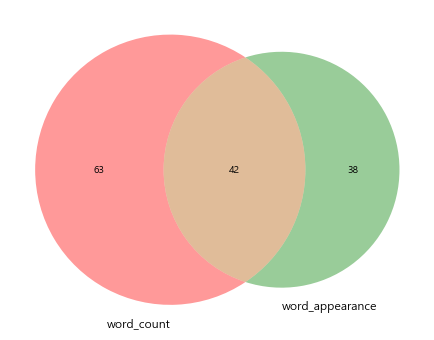

In [43]:
delayed = set(delayed_unique.index)
app_delayed = set(app_delayed_unique.index)
venn2([delayed, app_delayed], set_labels = ('word_count', 'word_appearance'))
plt.show()

# 5. 회귀분석 (문제 해결 후보 3)
- 로지스틱 회귀분석을 실시하였음. (종속변수(Y)와 독립변수(X) 간의 관계를 나태내어 예측모델을 생성한다는 점에서 선형회귀 분석과 비슷하지만, 종속변수(Y)의 결과가 범주형으로 분류 분석에 해당)
- 종속변수는 각 status일 것이고(범주형) / 독립변수는 각 단어들의 출현 빈도 (연속형)
- 로지스틱 회귀 분석은 종속변수(Y)에 로짓 변환을 실시. 위 로지스틱 모형식은 독립변수(X)의 값에 관계 없이 종속변수(Y)의 값이 항상 0 - 1 사이에 있도록 하는 것.
- https://myjamong.tistory.com/80 참고함

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# to save model
import pickle
import joblib
# from sklearn.externals import joblib는 이제 지원이 종료됨

In [24]:
df_reg = df
df_reg['deal_status'] = pd.Categorical(df_reg['deal_status'])
df_reg

deal_status                                          body_text  \
0     operation  Saudi Arabia-headquartered utilities company A...   
1     operation  Saudi-based Acwa Power, a major developer of p...   
2     operation  Tata Power has an installed hydro power capaci...   
3     operation  The project will generate around 450 GWh of cl...   
4     operation  Adjaristsqali Georgia (AGL), a joint venture b...   
..          ...                                                ...   
872     Delayed  Hybrid solar-wind-battery complex in Australia...   
873     Delayed  Plans to build the $12 billion Inga 3 hydropow...   
874     Delayed  Global Coal Plant Tracker shows project pipeli...   
875     Delayed  Floating solar project schedule in Seychelles ...   
876     Delayed  The resource you are looking for might have be...   

                                             word_list  jb  nee  rank  \
0    ['east', 'nation', 'saudi', 'communities', 'ho...   0    0     0   
1    ['east', 'operating', 'also', 'saudi', 'commun...   0    0     0   
2    ['hpp', 'gases', 'tata', 'also', 'georgia', 'e...   0    0     0   
3    ['gases', 'hpp', 'exclusively', 'tata', 'georg...   0    0     0   
4    ['hpp', 'institutions', 'gases', 'generated', ...   0    0     0   
..                                                 ...  ..  ...   ...   
872  ['update', 'become', 'wind', 'ongoing', 'facin...   0    0     0   
873  ['image', 'de', 'operating', 'become', 'presid...   0    0     0   
874  ['highlighted', 'bengal', 'slowed', 'defence',...   0    0     0   
875  ['mahe', 'lagoon', 'selected', 'delay', 'news'...   0    0     0   
876  ['looking', 'resource', 'unavailable', 'name',...   0    0     0   

     configuration  analysers  grants  competes  ...  funneled  lodged  \
0                0          0       0         0  ...         0       0   
1                0          0       0         0  ...         0       0   
2                0          0       0         0  ...         0       0   
3                0          0       0         0  ...         0       0   
4                0          0       0         0  ...         0       0   
..             ...        ...     ...       ...  ...       ...     ...   
872              0          0       0         0  ...         0       0   
873              0          0       0         0  ...         0       0   
874              0          0       0         0  ...         0       0   
875              0          0       0         0  ...         0       0   
876              0          0       0         0  ...         0       0   

     prides  lisa  wants  heal  maclennan  ozkan  modernization  grade  
0         0     0      0     0          0      0              0      0  
1         0     0      0     0          0      0              0      0  
2         0     0      0     0          0      0              0      0  
3         0     0      0     0          0      0              0      0  
4         0     0      0     0          0      0              0      0  
..      ...   ...    ...   ...        ...    ...            ...    ...  
872       0     0      0     0          0      0              0      0  
873       0     0      0     0          0      0              0      0  
874       0     0      0     0          0      0              0      0  
875       0     0      0     0          0      0              0      0  
876       0     0      0     0          0      0              0      0  

[877 rows x 18286 columns]

In [25]:
df_reg['deal_status_code'] = df_reg.deal_status.cat.codes
df_reg

deal_status                                          body_text  \
0     operation  Saudi Arabia-headquartered utilities company A...   
1     operation  Saudi-based Acwa Power, a major developer of p...   
2     operation  Tata Power has an installed hydro power capaci...   
3     operation  The project will generate around 450 GWh of cl...   
4     operation  Adjaristsqali Georgia (AGL), a joint venture b...   
..          ...                                                ...   
872     Delayed  Hybrid solar-wind-battery complex in Australia...   
873     Delayed  Plans to build the $12 billion Inga 3 hydropow...   
874     Delayed  Global Coal Plant Tracker shows project pipeli...   
875     Delayed  Floating solar project schedule in Seychelles ...   
876     Delayed  The resource you are looking for might have be...   

                                             word_list  jb  nee  rank  \
0    ['east', 'nation', 'saudi', 'communities', 'ho...   0    0     0   
1    ['east', 'operating', 'also', 'saudi', 'commun...   0    0     0   
2    ['hpp', 'gases', 'tata', 'also', 'georgia', 'e...   0    0     0   
3    ['gases', 'hpp', 'exclusively', 'tata', 'georg...   0    0     0   
4    ['hpp', 'institutions', 'gases', 'generated', ...   0    0     0   
..                                                 ...  ..  ...   ...   
872  ['update', 'become', 'wind', 'ongoing', 'facin...   0    0     0   
873  ['image', 'de', 'operating', 'become', 'presid...   0    0     0   
874  ['highlighted', 'bengal', 'slowed', 'defence',...   0    0     0   
875  ['mahe', 'lagoon', 'selected', 'delay', 'news'...   0    0     0   
876  ['looking', 'resource', 'unavailable', 'name',...   0    0     0   

     configuration  analysers  grants  competes  ...  lodged  prides  lisa  \
0                0          0       0         0  ...       0       0     0   
1                0          0       0         0  ...       0       0     0   
2                0          0       0         0  ...       0       0     0   
3                0          0       0         0  ...       0       0     0   
4                0          0       0         0  ...       0       0     0   
..             ...        ...     ...       ...  ...     ...     ...   ...   
872              0          0       0         0  ...       0       0     0   
873              0          0       0         0  ...       0       0     0   
874              0          0       0         0  ...       0       0     0   
875              0          0       0         0  ...       0       0     0   
876              0          0       0         0  ...       0       0     0   

     wants  heal  maclennan  ozkan  modernization  grade  deal_status_code  
0        0     0          0      0              0      0                 3  
1        0     0          0      0              0      0                 3  
2        0     0          0      0              0      0                 3  
3        0     0          0      0              0      0                 3  
4        0     0          0      0              0      0                 3  
..     ...   ...        ...    ...            ...    ...               ...  
872      0     0          0      0              0      0                 2  
873      0     0          0      0              0      0                 2  
874      0     0          0      0              0      0                 2  
875      0     0          0      0              0      0                 2  
876      0     0          0      0              0      0                 2  

[877 rows x 18287 columns]

In [26]:
new_col = df.columns.tolist()
del new_col[new_col.index('deal_status_code')]
new_col.insert(1, 'deal_status_code')
new_col

['deal_status',
 'deal_status_code',
 'body_text',
 'word_list',
 'jb',
 'nee',
 'rank',
 'configuration',
 'analysers',
 'grants',
 'competes',
 'authorise',
 'termination',
 'button',
 'denies',
 'kajima',
 'shell',
 'tc',
 'vst',
 'greco',
 'slhp',
 'settings',
 'pickering',
 'section',
 'allegation',
 'counterproductive',
 'farruggio',
 'worksite',
 'phasing',
 'ajk',
 'hydraulics',
 'axens',
 'kilometre',
 'gauge',
 'maturity',
 'legal',
 'farmland',
 'cargolux',
 'oppose',
 'turkana',
 'compassion',
 'rahmon',
 'conservator',
 'endorsing',
 'ritual',
 'anju',
 'whether',
 'medog',
 'azima',
 'jostle',
 'cent',
 'spending',
 'show',
 'eia',
 'thermax',
 'patil',
 'semco',
 'auspices',
 'thunderstorm',
 'structures',
 'zambezi',
 'outweighed',
 'fire',
 'report',
 'stealing',
 'taxes',
 'po',
 'interesting',
 'et',
 'ecuador',
 'kmp',
 'torn',
 'tara',
 'monuments',
 'dmtcl',
 'prohibitively',
 'bridges',
 'penh',
 'tickets',
 'unsurpassed',
 'retailer',
 'injustices',
 'stgs',
 'm

In [27]:
df_reg = df_reg[new_col]
df_reg

deal_status  deal_status_code  \
0     operation                 3   
1     operation                 3   
2     operation                 3   
3     operation                 3   
4     operation                 3   
..          ...               ...   
872     Delayed                 2   
873     Delayed                 2   
874     Delayed                 2   
875     Delayed                 2   
876     Delayed                 2   

                                             body_text  \
0    Saudi Arabia-headquartered utilities company A...   
1    Saudi-based Acwa Power, a major developer of p...   
2    Tata Power has an installed hydro power capaci...   
3    The project will generate around 450 GWh of cl...   
4    Adjaristsqali Georgia (AGL), a joint venture b...   
..                                                 ...   
872  Hybrid solar-wind-battery complex in Australia...   
873  Plans to build the $12 billion Inga 3 hydropow...   
874  Global Coal Plant Tracker shows project pipeli...   
875  Floating solar project schedule in Seychelles ...   
876  The resource you are looking for might have be...   

                                             word_list  jb  nee  rank  \
0    ['east', 'nation', 'saudi', 'communities', 'ho...   0    0     0   
1    ['east', 'operating', 'also', 'saudi', 'commun...   0    0     0   
2    ['hpp', 'gases', 'tata', 'also', 'georgia', 'e...   0    0     0   
3    ['gases', 'hpp', 'exclusively', 'tata', 'georg...   0    0     0   
4    ['hpp', 'institutions', 'gases', 'generated', ...   0    0     0   
..                                                 ...  ..  ...   ...   
872  ['update', 'become', 'wind', 'ongoing', 'facin...   0    0     0   
873  ['image', 'de', 'operating', 'become', 'presid...   0    0     0   
874  ['highlighted', 'bengal', 'slowed', 'defence',...   0    0     0   
875  ['mahe', 'lagoon', 'selected', 'delay', 'news'...   0    0     0   
876  ['looking', 'resource', 'unavailable', 'name',...   0    0     0   

     configuration  analysers  grants  ...  funneled  lodged  prides  lisa  \
0                0          0       0  ...         0       0       0     0   
1                0          0       0  ...         0       0       0     0   
2                0          0       0  ...         0       0       0     0   
3                0          0       0  ...         0       0       0     0   
4                0          0       0  ...         0       0       0     0   
..             ...        ...     ...  ...       ...     ...     ...   ...   
872              0          0       0  ...         0       0       0     0   
873              0          0       0  ...         0       0       0     0   
874              0          0       0  ...         0       0       0     0   
875              0          0       0  ...         0       0       0     0   
876              0          0       0  ...         0       0       0     0   

     wants  heal  maclennan  ozkan  modernization  grade  
0        0     0          0      0              0      0  
1        0     0          0      0              0      0  
2        0     0          0      0              0      0  
3        0     0          0      0              0      0  
4        0     0          0      0              0      0  
..     ...   ...        ...    ...            ...    ...  
872      0     0          0      0              0      0  
873      0     0          0      0              0      0  
874      0     0          0      0              0      0  
875      0     0          0      0              0      0  
876      0     0          0      0              0      0  

[877 rows x 18287 columns]

## 5-1) Operation vs. Others

In [28]:
# Prepare dataframe

def status_divisor(x:str, status:str):
    return 1 if x == status else 0

In [29]:
df_op_reg = df_reg
df_op_reg['deal_status_code'] = df_op_reg['deal_status'].apply(lambda x:status_divisor(x, 'operation'))
df_op_reg

deal_status  deal_status_code  \
0     operation                 1   
1     operation                 1   
2     operation                 1   
3     operation                 1   
4     operation                 1   
..          ...               ...   
872     Delayed                 0   
873     Delayed                 0   
874     Delayed                 0   
875     Delayed                 0   
876     Delayed                 0   

                                             body_text  \
0    Saudi Arabia-headquartered utilities company A...   
1    Saudi-based Acwa Power, a major developer of p...   
2    Tata Power has an installed hydro power capaci...   
3    The project will generate around 450 GWh of cl...   
4    Adjaristsqali Georgia (AGL), a joint venture b...   
..                                                 ...   
872  Hybrid solar-wind-battery complex in Australia...   
873  Plans to build the $12 billion Inga 3 hydropow...   
874  Global Coal Plant Tracker shows project pipeli...   
875  Floating solar project schedule in Seychelles ...   
876  The resource you are looking for might have be...   

                                             word_list  jb  nee  rank  \
0    ['east', 'nation', 'saudi', 'communities', 'ho...   0    0     0   
1    ['east', 'operating', 'also', 'saudi', 'commun...   0    0     0   
2    ['hpp', 'gases', 'tata', 'also', 'georgia', 'e...   0    0     0   
3    ['gases', 'hpp', 'exclusively', 'tata', 'georg...   0    0     0   
4    ['hpp', 'institutions', 'gases', 'generated', ...   0    0     0   
..                                                 ...  ..  ...   ...   
872  ['update', 'become', 'wind', 'ongoing', 'facin...   0    0     0   
873  ['image', 'de', 'operating', 'become', 'presid...   0    0     0   
874  ['highlighted', 'bengal', 'slowed', 'defence',...   0    0     0   
875  ['mahe', 'lagoon', 'selected', 'delay', 'news'...   0    0     0   
876  ['looking', 'resource', 'unavailable', 'name',...   0    0     0   

     configuration  analysers  grants  ...  funneled  lodged  prides  lisa  \
0                0          0       0  ...         0       0       0     0   
1                0          0       0  ...         0       0       0     0   
2                0          0       0  ...         0       0       0     0   
3                0          0       0  ...         0       0       0     0   
4                0          0       0  ...         0       0       0     0   
..             ...        ...     ...  ...       ...     ...     ...   ...   
872              0          0       0  ...         0       0       0     0   
873              0          0       0  ...         0       0       0     0   
874              0          0       0  ...         0       0       0     0   
875              0          0       0  ...         0       0       0     0   
876              0          0       0  ...         0       0       0     0   

     wants  heal  maclennan  ozkan  modernization  grade  
0        0     0          0      0              0      0  
1        0     0          0      0              0      0  
2        0     0          0      0              0      0  
3        0     0          0      0              0      0  
4        0     0          0      0              0      0  
..     ...   ...        ...    ...            ...    ...  
872      0     0          0      0              0      0  
873      0     0          0      0              0      0  
874      0     0          0      0              0      0  
875      0     0          0      0              0      0  
876      0     0          0      0              0      0  

[877 rows x 18287 columns]

In [33]:
# seperate independent variable & dependent variable

x = df_op_reg.loc[:, 'jb':'grade']
y = df_op_reg['deal_status_code']

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

657
220
657
220


In [51]:
op_log_reg = LogisticRegression()
op_log_reg.fit(x_train, y_train)

x2 = sm.add_constant(x)
model = sm.OLS(y, x2)
op_result = model.fit()
print(op_result.summary())

y_pred = op_log_reg.predict(x_test)
print(y_pred)
print(list(y_test))

print('정확도 :', metrics.accuracy_score(y_test, y_pred))

                            OLS Regression Results                            
Dep. Variable:       deal_status_code   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     1.373
Date:                Wed, 02 Sep 2020   Prob (F-statistic):              0.288
Time:                        21:49:16   Log-Likelihood:                 1430.5
No. Observations:                 877   AIC:                            -1129.
Df Residuals:                      11   BIC:                             3007.
Df Model:                         865                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

[1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1
 1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1
 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0
 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0
 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0]
[1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 

In [52]:
type(op_result)

statsmodels.regression.linear_model.RegressionResultsWrapper

### Sensitivity Analysis
변수 중요도 (variable importance, feature importance): 전체 관측치를 사용해 적합한 모델 단위의 변수별 (상대적) 중요도를 나타냄
관측치별 변수별 기여도(민감도): 개별 관측치 단위에서 한개의 칼럼이 모델 예측치에 얼마나 기여하는지를 나타냄
 -> 특정 관측치별로 개별적으로 어떤 변수가 예측치에 크게 영향을 미쳤는지 파악하기 위해서 사용

In [43]:
# UDF for contribution(sensitivity) analysis per each variables
# task: "LinearReg" or "LogitReg"
# 코드참조: https://rfriend.tistory.com/513 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

def sensitivity_analysis_LinearReg_LogitReg(task, model, X, idx, bar_plot_yn):
    pd.options.mode.chained_assignment = None
    
    # get one object's X values

    X_i = X.iloc[idx, :]
    # make a matrix with zeros with shape of [num_cols, num_cols]
    X_mat = np.zeros(shape=[X_i.shape[0], X_i.shape[0]])

    # fil X_mat with values from one by one columns, leaving the ohters zeros
    for i, j in enumerate(X_i):
        X_mat[i, i] = j
    # data frame with contribution of each X columns in descending order

    sensitivity_df = pd.DataFrame({'idx': idx, 'task': task, 'x': X_i, 'contribution_x': model.predict(X_mat)})
    

    # ==== Remark =====
    # when used LogisticRegressionsklearn from sklearn.linear_model
    
    if task == "LinearReg":
        sensitivity_df = pd.DataFrame({'idx': idx, 'task': task, 'x': X_i, 'contribution_x': model.predict(X_mat)})
    elif task == "LogitReg":
        sensitivity_df = pd.DataFrame({'idx': idx, 'task': task, 'x': X_i, 'contribution_x': model.predict_proba(X_mat)[:,1]})
    else:
        print('Please choose task one of "LinearReg" or "LogitReg"...')
    
    sensitivity_df = sensitivity_df.sort_values(by='contribution_x', ascending=True)

    
    # if bar_plot_yn == True then display it
    col_n = X_i.shape[0]

    if bar_plot_yn == True:
        sensitivity_df['contribution_x'].plot(kind='barh', figsize=(10, 0.7*col_n))
        plt.title('Sensitivity Analysis', fontsize=18)
        plt.xlabel('Contribution', fontsize=16)
        plt.ylabel('Variable', fontsize=16)
        plt.yticks(fontsize=14)
        plt.show()

    return sensitivity_df.sort_values(by='contribution_x', ascending=False)

In [54]:
# apply sensitivity analysis function on 1st observation for Logistic Regression

op_sensitivity_analysis = sensitivity_analysis_LinearReg_LogitReg(task="LogitReg", model=op_log_reg, X=x_test, idx=0, bar_plot_yn=False)

In [56]:
op_sensitivity_analysis.sort_values(by=['contribution_x'], axis=0, ascending=False)

idx      task  x  contribution_x
operation       0  LogitReg  1        0.544080
commercial      0  LogitReg  1        0.538227
purchase        0  LogitReg  1        0.382634
service         0  LogitReg  1        0.342183
providing       0  LogitReg  1        0.340523
...           ...       ... ..             ...
two             0  LogitReg  1        0.221395
line            0  LogitReg  1        0.216956
due             0  LogitReg  1        0.207718
project         0  LogitReg  1        0.193234
construction    0  LogitReg  1        0.172192

[18283 rows x 4 columns]

In [57]:
reg_operation_result_100 = op_sensitivity_analysis['contribution_x'].nlargest(100)
reg_operation_vocab = reg_operation_result_100.index.tolist()

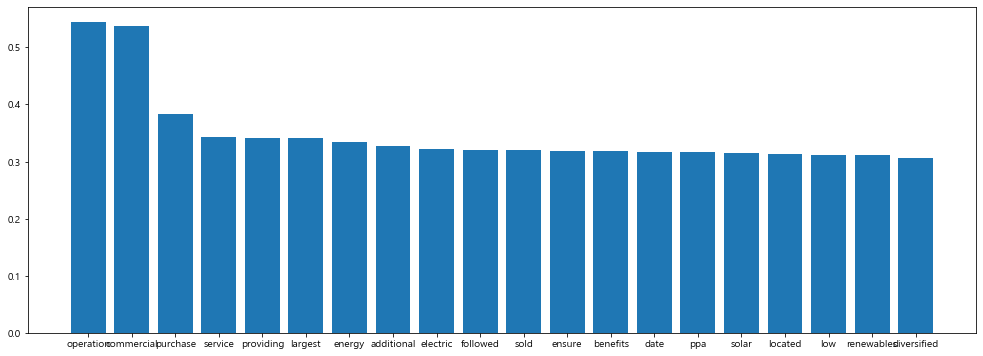

In [58]:
# The top 20s of the important vocabs in the operation
y = reg_operation_result_100.nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

## 5-2) Cancelled vs. Others

In [60]:
# Prepare dataframe

df_ca_reg = df_reg
df_ca_reg['deal_status_code'] = df_ca_reg['deal_status'].apply(lambda x:status_divisor(x, 'Cancelled'))

# seperate independent variable & dependent variable
x = df_ca_reg.loc[:, 'jb':'grade']
y = df_ca_reg['deal_status_code']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

ca_log_reg = LogisticRegression()
ca_log_reg.fit(x_train, y_train)

x2 = sm.add_constant(x)
model = sm.OLS(y, x2)
ca_result = model.fit()
print(ca_result.summary())

y_pred = ca_log_reg.predict(x_test)
print(y_pred)
print(list(y_test))

print('정확도 :', metrics.accuracy_score(y_test, y_pred))

                            OLS Regression Results                            
Dep. Variable:       deal_status_code   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     1.691
Date:                Wed, 02 Sep 2020   Prob (F-statistic):              0.163
Time:                        21:54:01   Log-Likelihood:                 1824.9
No. Observations:                 877   AIC:                            -1918.
Df Residuals:                      11   BIC:                             2219.
Df Model:                         865                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [61]:
# apply sensitivity analysis function on 1st observation for Logistic Regression

ca_sensitivity_analysis = sensitivity_analysis_LinearReg_LogitReg(task="LogitReg", model=ca_log_reg, X=x_test, idx=0, bar_plot_yn=False)
ca_sensitivity_analysis.sort_values(by=['contribution_x'], axis=0, ascending=False)

idx      task  x  contribution_x
due             0  LogitReg  1        0.093888
projects        0  LogitReg  1        0.092718
city            0  LogitReg  1        0.086677
part            0  LogitReg  1        0.086180
said            0  LogitReg  1        0.085180
...           ...       ... ..             ...
largest         0  LogitReg  1        0.054644
service         0  LogitReg  1        0.049952
construction    0  LogitReg  1        0.049368
commercial      0  LogitReg  1        0.044415
operation       0  LogitReg  1        0.042513

[18283 rows x 4 columns]

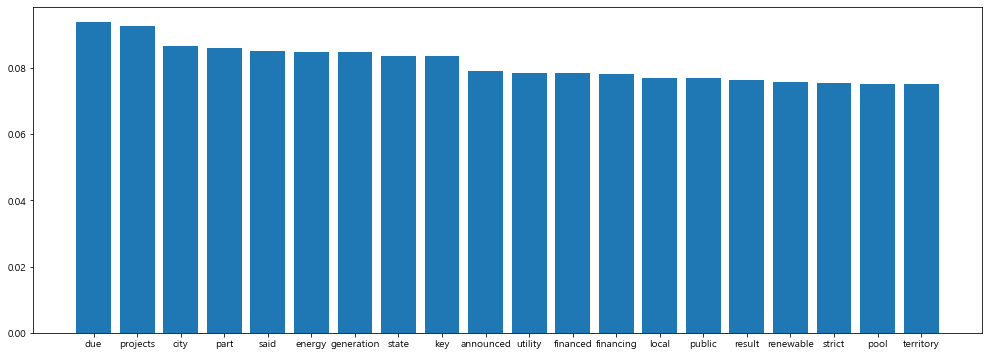

In [62]:
reg_cancelled_result_100 = ca_sensitivity_analysis['contribution_x'].nlargest(100)
reg_cancelled_vocab = reg_cancelled_result_100.index.tolist()

# The top 20s of the important vocabs in cancelled
y = reg_cancelled_result_100.nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

## 5-3) Delayed vs. Others

In [63]:
# Prepare dataframe

df_de_reg = df_reg
df_de_reg['deal_status_code'] = df_de_reg['deal_status'].apply(lambda x:status_divisor(x, 'Delayed'))

# seperate independent variable & dependent variable
x = df_de_reg.loc[:, 'jb':'grade']
y = df_de_reg['deal_status_code']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

de_log_reg = LogisticRegression()
de_log_reg.fit(x_train, y_train)

x2 = sm.add_constant(x)
model = sm.OLS(y, x2)
de_result = model.fit()
print(de_result.summary())

y_pred = de_log_reg.predict(x_test)
print(y_pred)
print(list(y_test))

print('정확도 :', metrics.accuracy_score(y_test, y_pred))

                            OLS Regression Results                            
Dep. Variable:       deal_status_code   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.948e+26
Date:                Wed, 02 Sep 2020   Prob (F-statistic):          9.88e-147
Time:                        21:57:13   Log-Likelihood:                 28714.
No. Observations:                 877   AIC:                        -5.570e+04
Df Residuals:                      11   BIC:                        -5.156e+04
Df Model:                         865                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [64]:
# apply sensitivity analysis function on 1st observation for Logistic Regression

de_sensitivity_analysis = sensitivity_analysis_LinearReg_LogitReg(task="LogitReg", model=de_log_reg, X=x_test, idx=0, bar_plot_yn=False)
de_sensitivity_analysis.sort_values(by=['contribution_x'], axis=0, ascending=False)

idx      task  x  contribution_x
project        0  LogitReg  1        0.027477
said           0  LogitReg  1        0.026012
line           0  LogitReg  1        0.023787
services       0  LogitReg  1        0.023461
due            0  LogitReg  1        0.023173
...          ...       ... ..             ...
located        0  LogitReg  1        0.015224
development    0  LogitReg  1        0.015197
million        0  LogitReg  1        0.014227
capacity       0  LogitReg  1        0.013657
power          0  LogitReg  1        0.013272

[18283 rows x 4 columns]

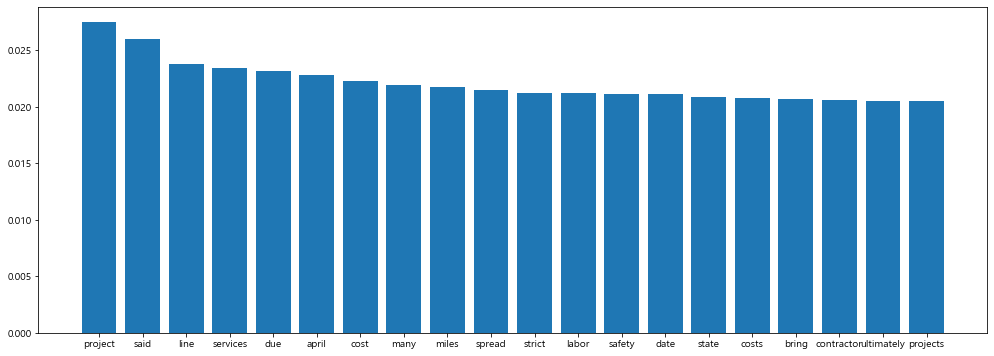

In [65]:
reg_delayed_result_100 = de_sensitivity_analysis['contribution_x'].nlargest(100)
reg_delayed_vocab = reg_delayed_result_100.index.tolist()

# The top 20s of the important vocabs in delayed
y = reg_delayed_result_100.nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

## 5-4) Active vs. Others

In [44]:
# Prepare dataframe

df_ac_reg = df_reg
df_ac_reg['deal_status_code'] = df_ac_reg['deal_status'].apply(lambda x:status_divisor(x, 'Active'))

# seperate independent variable & dependent variable
x = df_ac_reg.loc[:, 'jb':'grade']
y = df_ac_reg['deal_status_code']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

ac_log_reg = LogisticRegression()
ac_log_reg.fit(x_train, y_train)

x2 = sm.add_constant(x)
model = sm.OLS(y, x2)
ac_result = model.fit()
print(ac_result.summary())

y_pred = ac_log_reg.predict(x_test)
print(y_pred)
print(list(y_test))

print('정확도 :', metrics.accuracy_score(y_test, y_pred))

                            OLS Regression Results                            
Dep. Variable:       deal_status_code   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     1.986
Date:                Sat, 05 Sep 2020   Prob (F-statistic):             0.0984
Time:                        17:28:44   Log-Likelihood:                 1659.5
No. Observations:                 877   AIC:                            -1587.
Df Residuals:                      11   BIC:                             2549.
Df Model:                         865                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

[0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1
 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0]
[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 

In [46]:
# apply sensitivity analysis function on 1st observation for Logistic Regression

ac_sensitivity_analysis = sensitivity_analysis_LinearReg_LogitReg(task="LogitReg", model=ac_log_reg, X=x_test, idx=0, bar_plot_yn=False)
ac_sensitivity_analysis.sort_values(by=['contribution_x'], axis=0, ascending=False)

idx      task   x  contribution_x
construction    0  LogitReg   2        0.721434
project         0  LogitReg  11        0.627613
county          0  LogitReg   1        0.567686
development     0  LogitReg   1        0.547923
site            0  LogitReg   1        0.536108
...           ...       ...  ..             ...
electric        0  LogitReg   4        0.326103
operation       0  LogitReg   1        0.316429
city            0  LogitReg   2        0.236765
energy          0  LogitReg   6        0.177095
solar           0  LogitReg   7        0.061786

[18283 rows x 4 columns]

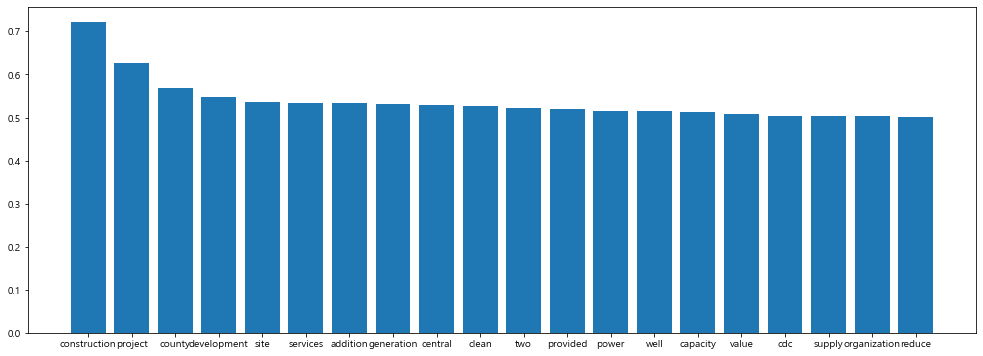

In [47]:
reg_active_result_100 = ac_sensitivity_analysis['contribution_x'].nlargest(100)
reg_active_vocab = reg_active_result_100.index.tolist()

# The top 20s of the important vocabs in active
y = reg_active_result_100.nlargest(20)
x = y.index.tolist()

plt.bar(x, y)
plt.show()

- p-value는, 귀무가설(null hypothesis, H0)이 맞다는 전제 하에, 통계값(statistics)1이 실제로 관측된 값 이상일 확률을 의미
- p-value가 작은 단어들을 보면, const(0.003), jb(0.158), authorise(0.116), settings (0.095), stabilise(0.112)...? 머지...
- multicollinearity problems가 의심되므로 서로 연관 있는 단어를 삭제하여야 함.

# 6. 의사결정나무 (문제 해결 후보 4)

In [53]:
# The names of the DataFrames: df_op_reg. df_ca_reg, df_de_reg, df_ac_reg
# import libraries
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython.display import Image
import pydotplus
import os

In [65]:
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz 2.44.1\bin/'

In [54]:
# seperate independent variable & dependent variable

x = df_op_reg.loc[:, 'jb':'grade']
y = df_op_reg['deal_status_code']

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

657
220
657
220


In [56]:
# use every leaf nodes
dt_clf_op = DecisionTreeClassifier(random_state = 0)
dt_clf_op.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [57]:
y_pred = dt_clf_op.predict(x_test)

print('정확도 :', metrics.accuracy_score(y_test, y_pred))

정확도 : 0.8


In [58]:
feature_names = x.columns.tolist()
target_name = np.array(['Else', 'Operation'])

In [59]:
dt_op_dot = tree.export_graphviz(dt_clf_op, out_file = None,
                                  feature_names = feature_names,
                                  class_names = target_name,
                                  filled = True, rounded = True,
                                  special_characters = True)

In [60]:
dt_graph = pydotplus.graph_from_dot_data(dt_op_dot)

In [66]:
Image(dt_graph.create_png())

InvocationException: GraphViz's executables not found

# 7. 결론 및 개선점

In [41]:
from wordcloud import WordCloud

In [44]:
op_list = operation_unique.index.tolist()

In [52]:
op_tup = []
for e in op_list:
    temp = e, operation_unique.loc[e]
    op_tup.append(temp)
op_tup

[('business', 137),
 ('completed', 124),
 ('provide', 123),
 ('area', 107),
 ('corporation', 110),
 ('supply', 143),
 ('announced', 118),
 ('increase', 110),
 ('operational', 107),
 ('located', 173),
 ('ge', 117),
 ('ormat', 132),
 ('group', 183),
 ('mw', 518),
 ('started', 142),
 ('renewables', 137),
 ('service', 120),
 ('duke', 109),
 ('income', 112),
 ('golar', 106),
 ('operation', 407),
 ('lng', 263),
 ('services', 139),
 ('around', 132),
 ('nuclear', 107),
 ('may', 137),
 ('solar', 563),
 ('part', 121),
 ('texas', 113),
 ('wind', 522),
 ('turbines', 144),
 ('system', 140),
 ('generation', 185),
 ('adjusted', 118),
 ('commercial', 390),
 ('net', 143),
 ('south', 122),
 ('agreement', 115),
 ('approximately', 107),
 ('station', 106),
 ('phase', 123),
 ('december', 136),
 ('plants', 129),
 ('facility', 181),
 ('vietnam', 111),
 ('geothermal', 151),
 ('operating', 138),
 ('market', 144),
 ('share', 120),
 ('us', 148),
 ('including', 119),
 ('expressway', 240),
 ('province', 122),
 ('to

In [53]:
# 히히 워드클라우드 만드는중
wc = WordCloud()
WordCloud.generate_from_frequencies(dict(op_tup))

TypeError: generate_from_frequencies() missing 1 required positional argument: 'frequencies'